<a href="https://colab.research.google.com/github/pavitraa0625/improved-parakeet/blob/main/Jyesta_Mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Loaded: (1048327, 13)
Columns: Index(['brewery_id', 'brewery_name', 'review_time', 'review_overall',
       'review_aroma', 'review_appearance', 'review_profilename', 'beer_style',
       'review_palate', 'review_taste', 'beer_name', 'beer_abv',
       'beer_beerid'],
      dtype='object')
📊 Cleaned Dataset: (9999, 3)


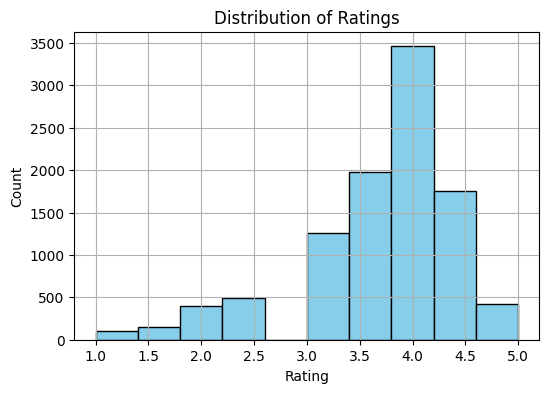

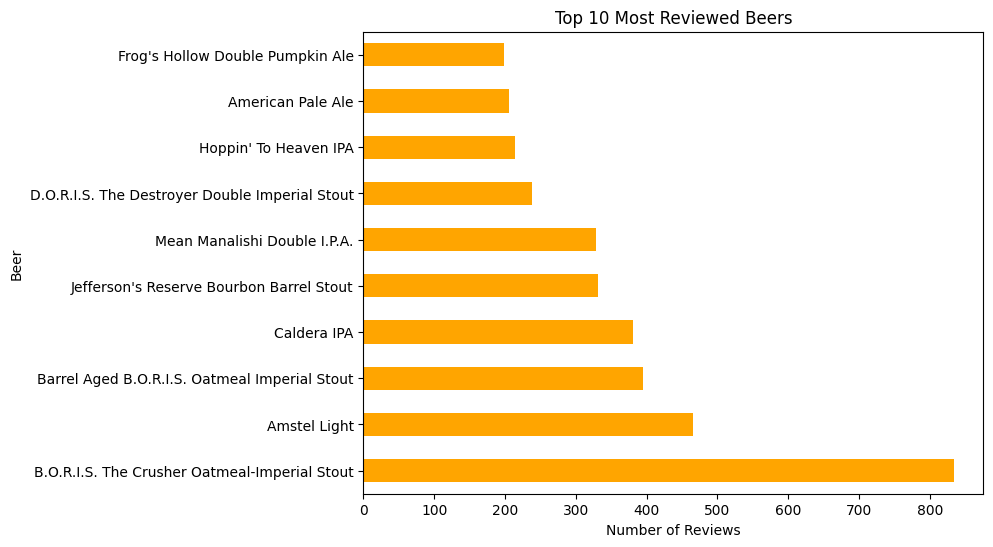

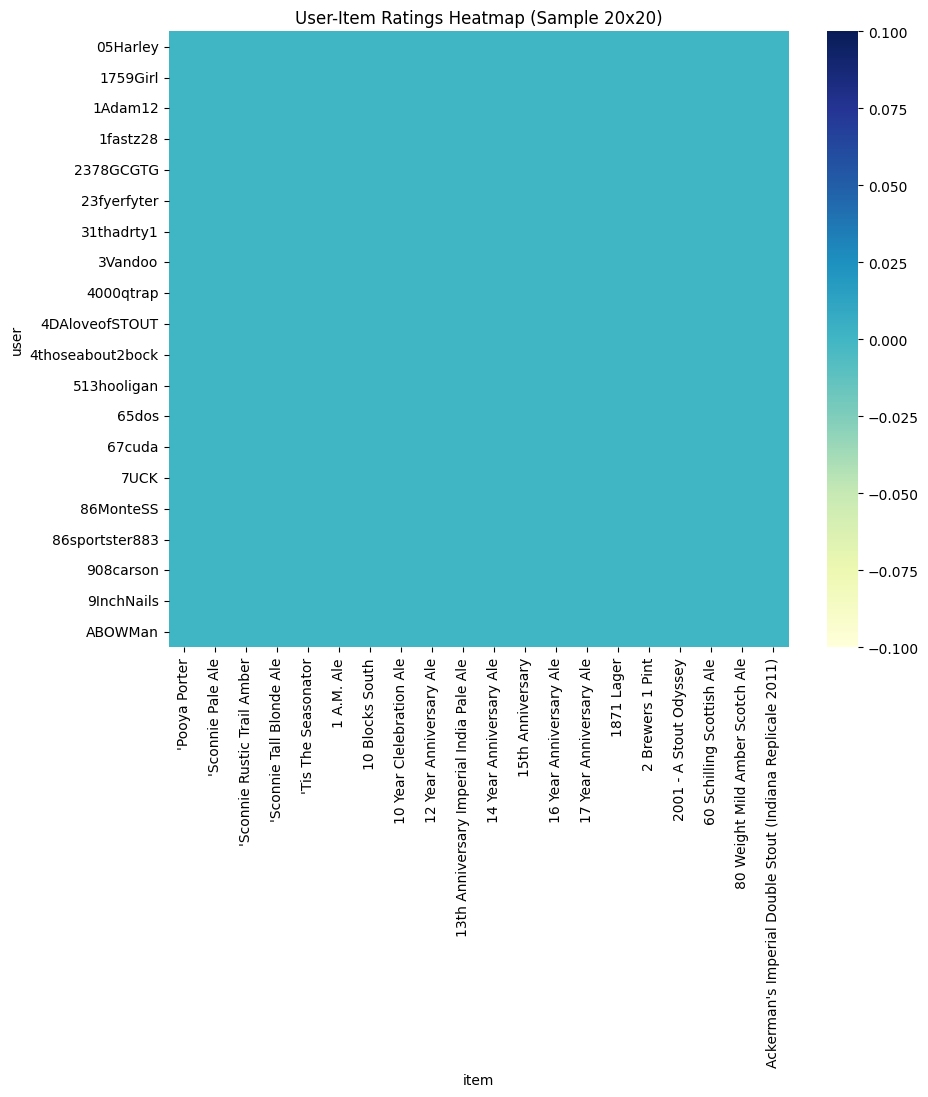


🎯 User-based Recommendations for 05Harley :
 ["'Pooya Porter", "'Sconnie Pale Ale", "'Sconnie Rustic Trail Amber", "'Sconnie Tall Blonde Ale", "'Tis The Seasonator"]

🍺 Item-based Recommendations for 05Harley :
 ['Barrel Aged B.O.R.I.S. Oatmeal Imperial Stout', 'B.O.R.I.S. The Crusher Oatmeal-Imperial Stout', 'Hop Dam Triple IPA', "Frog's Hollow Double Pumpkin Ale", 'Outta Kilter']

📏 RMSE for 05Harley: 0.13364806813774965
precision@5: 0.00, Recall@5: 0.00


In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt

filename = "beer_reviews.csv"
df = pd.read_csv(filename, low_memory=False)

print("Dataset Loaded:", df.shape)
print("Columns:", df.columns)


df = df[['review_profilename', 'beer_name', 'review_overall']]
df = df.dropna()
df.columns = ['user', 'item', 'rating']
df['user'] = df['user'].astype(str)
df['item'] = df['item'].astype(str)
df['rating'] = df['rating'].astype(float)

print("📊 Cleaned Dataset:", df.shape)

plt.figure(figsize=(6,4))
df['rating'].hist(bins=10, edgecolor='black', color="skyblue")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Top 10 Most Reviewed Beers
top_beers = df['item'].value_counts().head(10)
top_beers.plot(kind='barh', figsize=(8,6), color='orange')
plt.title("Top 10 Most Reviewed Beers")
plt.xlabel("Number of Reviews")
plt.ylabel("Beer")
plt.show()

user_item_matrix = df.pivot_table(index='user', columns='item', values='rating')
sample_matrix = user_item_matrix.iloc[:20, :20].fillna(0)
plt.figure(figsize=(10,8))
sns.heatmap(sample_matrix, cmap="YlGnBu")
plt.title("User-Item Ratings Heatmap (Sample 20x20)")
plt.show()

user_matrix_filled = user_item_matrix.fillna(0)
user_similarity = cosine_similarity(user_matrix_filled)
user_similarity_df = pd.DataFrame(user_similarity,
                                  index=user_item_matrix.index,
                                  columns=user_item_matrix.index)

def recommend_user_based(user, top_n=5):
    if user not in user_item_matrix.index:
        return ["User not found!"]

    similar_users = user_similarity_df[user].sort_values(ascending=False)[1:6].index
    similar_ratings = user_item_matrix.loc[similar_users].mean().sort_values(ascending=False)
    rated_items = user_item_matrix.loc[user].dropna().index
    recommendations = [item for item in similar_ratings.index if item not in rated_items][:top_n]

    return recommendations

item_matrix_filled = user_item_matrix.fillna(0).T
item_similarity = cosine_similarity(item_matrix_filled)
item_similarity_df = pd.DataFrame(item_similarity,
                                  index=user_item_matrix.columns,
                                  columns=user_item_matrix.columns)

def recommend_item_based(user, top_n=5):
    if user not in user_item_matrix.index:
        return ["User not found!"]

    user_ratings = user_item_matrix.loc[user].dropna()
    scores = {}

    for item, rating in user_ratings.items():
        similar_items = item_similarity_df[item].sort_values(ascending=False)[1:6]
        for similar_item, sim in similar_items.items():
            if similar_item not in user_ratings.index:
                scores[similar_item] = scores.get(similar_item, 0) + sim * rating

    recommendations = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [item for item, score in recommendations][:top_n]


def evaluate_rmse(user):
    if user not in user_item_matrix.index:
        return None
    actual, predicted = [], []

    for item in user_item_matrix.columns:
        if pd.notna(user_item_matrix.loc[user, item]):
            actual.append(user_item_matrix.loc[user, item])
            sims = user_similarity_df[user].drop(user)
            weighted_sum, sim_sum = 0, 0
            for other_user, sim in sims.items():
                if pd.notna(user_item_matrix.loc[other_user, item]):
                    weighted_sum += sim * user_item_matrix.loc[other_user, item]
                    sim_sum += sim
            if sim_sum > 0:
                predicted.append(weighted_sum / sim_sum)
            else:
                predicted.append(np.mean(user_item_matrix[item].dropna()))

    if len(actual) > 0 and len(predicted) > 0:
        return sqrt(mean_squared_error(actual, predicted))
    else:
        return None

def precision_recall_at_k(user, k=5):
    user_recs = recommend_user_based(user, top_n=k)
    actual_items = user_item_matrix.loc[user].dropna().index
    hits = len(set(user_recs) & set(actual_items))
    precision = hits / k
    recall = hits / len(actual_items) if len(actual_items) > 0 else 0
    return precision, recall


target_user = "05Harley"

print("\n🎯 User-based Recommendations for", target_user, ":\n", recommend_user_based(target_user))
print("\n🍺 Item-based Recommendations for", target_user, ":\n", recommend_item_based(target_user))

rmse = evaluate_rmse(target_user)
precision, recall = precision_recall_at_k(target_user)

print(f"\n📏 RMSE for {target_user}: {rmse}")
print(f"precision@5: {precision:.2f}, Recall@5: {recall:.2f}")
